# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [9]:
!pip install jsonlines
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict
from tqdm import tqdm

## I. N-Gram Language Modeling

#### Utilities

In [10]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
  # model: lm, sequence: validation set
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [11]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        # n-gram --n
        self.n = n
        # add a fixed 'pseudo-count'  𝛿  to avoid zero probability --delta
        self.delta = delta
        # count:{["<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...}
        self.count = defaultdict(lambda: defaultdict(float))
        # total:{"candy":17, "the":100,...}
        self.total = defaultdict(float)
        # vocabulary size+1 --vsize
        self.vsize = vsize
    
    def estimate(self, sequences):
      # sequences: datasets["train"] with 78274 sentences
        for sequence in sequences:
          # sequence:['Valkyria', 'of', 'the', 'Battlefield', '3', ')', ...]
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            # sequence: ["<bos>","<bos>",'Valkyria', 'of', 'the', 'Battlefield', '3', ')', ...]
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [12]:
datasets, vocab = load_wikitext()
print()
delta = 0.0005
for n in [2,3,4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

/bin/sh: wget: command not found


FileNotFoundError: [Errno 2] No such file or directory: 'wikitext2-sentencized.json'

### I.1 Interpolation

In [142]:
# parameter lambda
l=defaultdict(list)
# equal:
l[2]=[1/3,1/3,1/3]
l[3]=[1/4,1/4,1/4,1/4]
l[4]=[1/5,1/5,1/5,1/5,1/5]
# increasing:
l[2]=[1/6,1/3,1/2]
l[3]=[1/10,1/5,3/10,2/5]
l[4]=[1/15,2/15,3/15,4/15,5/15]
# increasing more:
l[2]=[1/111,10/111,100/111]
l[3]=[1/131,10/131,100/131,20/131]
l[4]=[1/132,10/132,100/132,20/132,1/132]
datasets, vocab = load_wikitext()

Vocab size: 33175


In [ ]:
class NGramInterpolation(object):
    def __init__(self, n, vsize):
        # n-gram --n
        self.n = n
        # count:{"2":{["<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...}}
        self.count1 = defaultdict(float)
        self.count2 = defaultdict(lambda: defaultdict(float))
        self.total2 = defaultdict(float)
        self.count3 = defaultdict(lambda: defaultdict(float))
        self.total3 = defaultdict(float)
        self.count4 = defaultdict(lambda: defaultdict(float))
        self.total4 = defaultdict(float)
        # vocabulary size+1 --vsize
        self.vsize = vsize

    def estimate(self, sequences):
      for j in range(1,self.n+1):
        # n=2,3,4
        for sequence in sequences:
            padded_sequence = ['<bos>']*(j-1) + sequence + ['<eos>']
            # padded_sequence=[<bos>,i,am,chasing,a,rabbit,<eos>]
            for i in range(len(padded_sequence) - j+1):
              # j=2, i=0
                ngram = tuple(padded_sequence[i:i+j])
                #print(j,ngram)
                #break
                # ngram=[<bos>,i]
                prefix, word = ngram[:-1], ngram[-1]
                # prefix=[<bos>],word=[i]
                # count:{2:{
                            # ["<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...},
                      #  3:{
                            # ["<bos>","<bos>","<bos>"]:{"candy":7.0,"the":8.0...}...},
                # count[2][i][<bos>]+=1
                if j==1:self.count1[word] += 1
                if j==2:self.count2[prefix][word] += 1
                if j==3:self.count3[prefix][word] += 1
                if j==4:self.count4[prefix][word] += 1
                # total:{3:{('<bos>', '<bos>', '<bos>'):5,...},
                      #  4:{('<bos>', '<bos>', '<bos>',"<bos>":100,...}}
                if j==2:self.total2[prefix] += 1
                if j==3:self.total3[prefix] += 1
                if j==4:self.total4[prefix] += 1
        self.k=sum(list(self.count1.values()))
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
      #print(self.count)
      prob=(1/(self.vsize))*l[self.n][0]
      for i in range(1,self.n+1):
        prefix = ngram[-i:-1]
        word = ngram[-1]
        if i==1:
          prob += (l[self.n][i])*self.count1[word]/self.k
        if i==2:
          prob += (l[self.n][i]*self.count2[prefix][word])/ max(self.total2[prefix],1)
        if i==3:
          prob += (l[self.n][i]*self.count3[prefix][word])/ max(self.total3[prefix],1)
        if i==4:
          prob += (l[self.n][i]*self.count4[prefix][word])/ max(self.total4[prefix],1)
      return prob
  

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [151]:
datasets, vocab = load_wikitext()
for n in [2,3,4]:
    lm1 = NGramInterpolation(n=n, vsize=len(vocab)+1)  # +1 is for <eos>
    lm1.estimate(datasets['train'])

    print("The value of lambda: {}".format(l[n]))
    print("Baseline (Interpolation, n=%d)) Train Perplexity: %.3f" % (n,  perplexity(lm1, datasets['train'])))
    print("Baseline (Interpolation, n=%d)) Valid Perplexity: %.3f" % (n,  perplexity(lm1, datasets['valid'])))

Vocab size: 33175
The value of lambda: [0.009009009009009009, 0.09009009009009009, 0.9009009009009009]
Baseline (Interpolation, n=2)) Train Perplexity: 83.113
Baseline (Interpolation, n=2)) Valid Perplexity: 338.879
The value of lambda: [0.007633587786259542, 0.07633587786259542, 0.7633587786259542, 0.15267175572519084]
Baseline (Interpolation, n=3)) Train Perplexity: 23.235
Baseline (Interpolation, n=3)) Valid Perplexity: 320.460
The value of lambda: [0.007575757575757576, 0.07575757575757576, 0.7575757575757576, 0.15151515151515152, 0.007575757575757576]
Baseline (Interpolation, n=4)) Train Perplexity: 18.167
Baseline (Interpolation, n=4)) Valid Perplexity: 319.789


In [8]:
lm1.total3.items()[:5]

NameError: name 'lm1' is not defined

In [15]:
'''
Iterate over all the key value pairs in dictionary and call the given
callback function() on each pair. Items for which callback() returns True,
add them to the new dictionary. In the end return the new dictionary.
'''
def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict
d={1:3,5:7,4:6}
filterTheDict(d, lambda elem : elem[0] % 2 == 0)

{4: 6}

## II. Neural Language Modeling with a Recurrent Neural Network

In [ ]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

### II.1 LSTM and Hyper-Parameters

#### Results (LSTM vs. Baseline)

#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


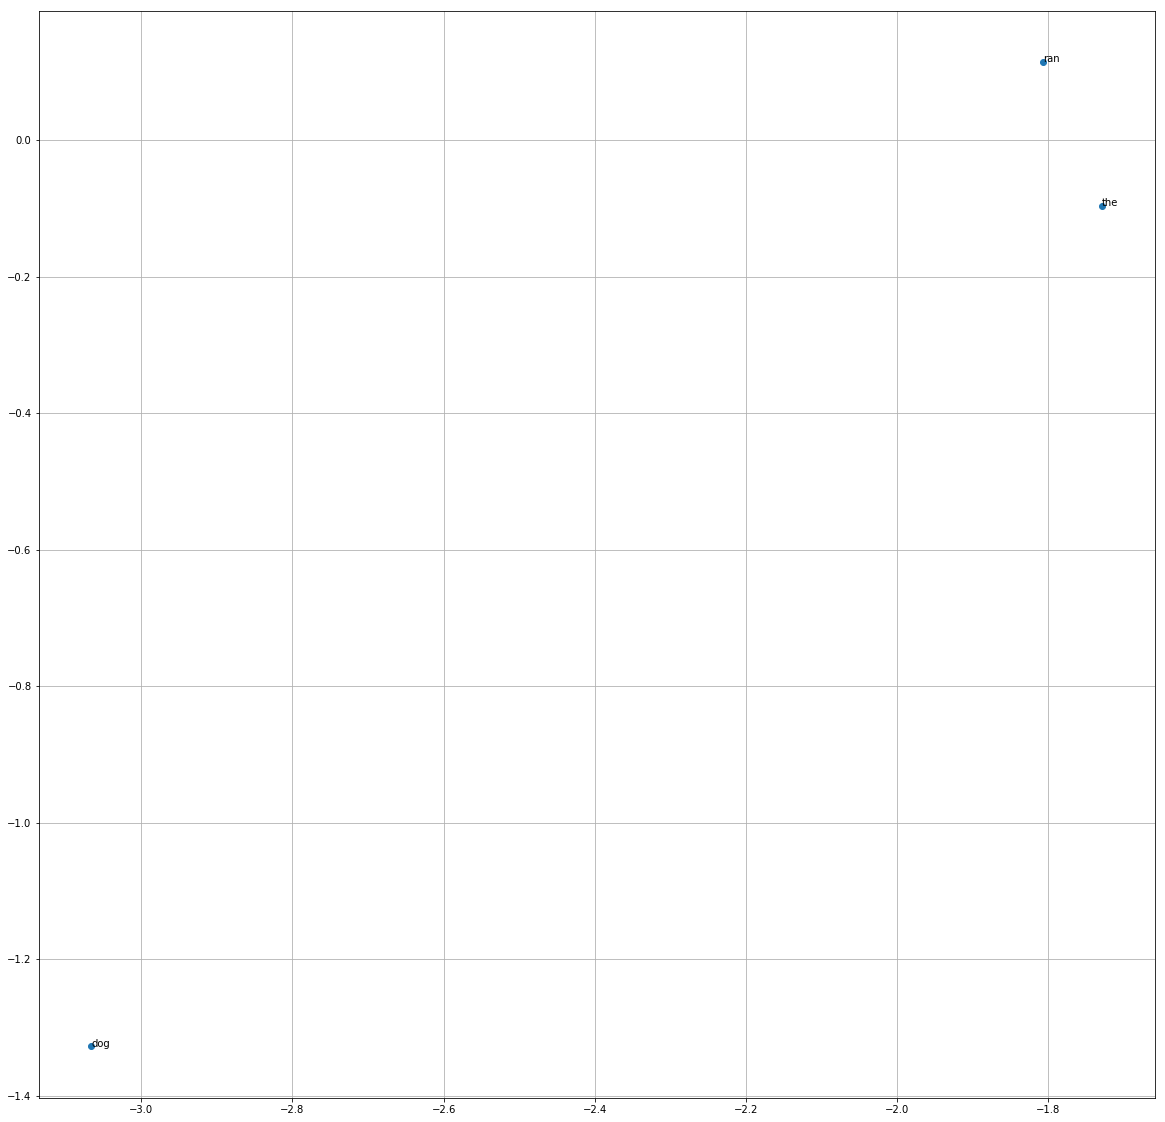

In [ ]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples